In [ ]:

epsilon = 0.1
hypothesis_class_cardinality = 10000
interpolation_mode = "continuous"


In [ ]:
data_path = '/content/drive/My Drive/Simulations in Stat learning/data/'
distributions_path = '/content/drive/My Drive/Simulations in Stat learning/distributions/'
videos_path = '/content/drive/My Drive/Simulations in Stat learning/videos/'

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import pyplot as plt
from matplotlib import animation
import matplotlib
%matplotlib inline
from scipy.stats import multivariate_normal
import pickle
import os
import itertools
import random

In [ ]:

true_unknown_distribution = "circle"
is_agnostic = False




In [ ]:
np.random.seed(42)
#Standard
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams['axes.linewidth'] = 7
plt.rcParams['savefig.facecolor']='blue'
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.rcParams['xtick.major.pad']='25'
plt.rcParams['ytick.major.pad']='25'

# Supporting Functions

In [ ]:
import math

def nCr(n,r):
    f = math.factorial
    return f(n) / f(r) / f(n-r)


In [ ]:
#CUSTOM COLORMAPS

label_colors = matplotlib.colors.ListedColormap(['silver', 'Black'])
right_wrong_colors = matplotlib.colors.ListedColormap(['tomato', 'forestgreen'])
hypothesis_colors = matplotlib.colors.ListedColormap(['tomato', 'silver'])


In [ ]:
#norm = colors.Normalize(0, 1)
def get_facecolors(array,mode,alpha = 1):
    shape = array.shape
    p = (-1,)
    if mode == "greenred":
        colors = right_wrong_colors(array.reshape(-1),alpha)
    if mode == "greyred":
        colors = hypothesis_colors(array.reshape(-1),alpha)
    if mode == "black":
        
        colors = cm.binary(array.reshape(-1),alpha)
        
    return colors.reshape(shape + p)

In [ ]:
#This get labels is slightly different from the one in hoeffdings inequality notebook
def get_labels(x,y,distribution):
    if distribution == "circle":
        z = np.where(x**2 + y**2 + 2*0.9*x + 2*0.5*y - 0.2 > 0 , 1 , 0)  
        
    elif distribution == "linear":
        h_labeling = np.array([0.7,0.5])
        
        temp = np.c_[x,y]   #---for animation
        z = np.where(np.matmul(temp,h_labeling) - 0> 0.0, 1, 0)
        
    elif distribution =="wiggly1":
        z = np.where(3*y**3 +x**2 -0.2*y**2 +  0*x - 0.01   >0, 1, 0)
        
    elif distribution =="wiggly2":
        z = np.where(30*x**10 + 2*y**10 -700*x**7 + 20*y**5 -1*x**2 + 0.02   >0, 0, 1)
        
    elif distribution == "l1":
        z1 = np.where(abs(x)+abs(y)>0.15,1,0)
        z2 = np.where(abs(x)+abs(y)>0.4,1,0)

        z = np.logical_xor(z1,z2)
    
    else :
        filename = distributions_path + distribution + ".png"
        im = plt.imread(filename)
        image = np.round(np.sum(im,2)/3)

        x_ = np.floor((x + 0.4)*1000)
        y_ = np.floor((y + 0.4)*1000)

        labels = []
        for i,j in zip(x_.astype(int),y_.astype(int)):

            label = image[i,j]
            labels.append(label)

        z = np.abs(1 - np.array(labels))
    
    
        
    return z

In [ ]:
def errors_on_hypothesis_set(data,hypothesis):
    intermediate = np.matmul(data[:,:2], hypothesis)
    predictions = np.where(intermediate > 0.0, 1, 0)
    labels = data[:,2]

    E_out = np.logical_xor(predictions.T,labels)
    true_errors = 1 - np.sum(E_out,axis=1)/E_out.shape[1]
    
    return true_errors,E_out,predictions  #this depends on which all hypothesis I want to animate on

__________________________________________________________________________________________________________________

# All the knobs

In [ ]:
#PAC LEARNING
#All the knobs here

distribution = true_unknown_distribution
agnostic = is_agnostic
#interpolation_type = 

if agnostic:
  name = "agnostic"
else:
  name = distribution



e = epsilon
vc_dim = 2



#THE HYPOTHESIS SPACE
num_hypothesis = hypothesis_class_cardinality
hypothesis = np.random.uniform(-1,1,[2,num_hypothesis])
h8 = np.array([[0.5,0.5],
               [0.5,0],
               [0.5,-0.5],
               [-0.5,0.5],
               [-0.5,0],
               [-0.5,-0.5],
               [0,0.5],
               [0,-0.5]])
hypothesis[:,:8] = h8.T













In [ ]:
n = 150 #training + ghost size
rare = True
if n >= 10:
  realthing = False
else:
  realthing = True

In [ ]:

if rare:
  data = np.random.uniform(-0.35,-0.36,[n,2])
else:
  data = np.random.uniform(-0.4,0.4,[n,2])
#
labels = get_labels(data[:,0],data[:,1],distribution).astype(int)
data = np.c_[data,labels]

indices = np.array(range(data.shape[0]))

In [ ]:
intermediate = np.matmul(data[:,:2], hypothesis)
predictions = np.where(intermediate > 0.0, 1, 0)
E_out = np.logical_xor(predictions.T,data[:,2])/int(n/2)


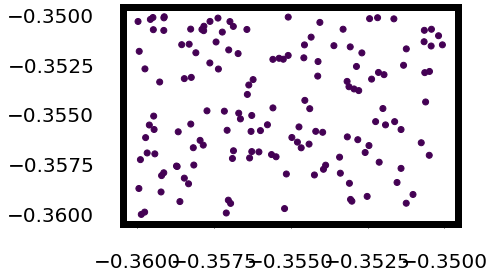

In [ ]:
plt.scatter(data[:,0],data[:,1],c= data[:,2])

In [ ]:
#doing the real thing

if realthing:
  x = itertools.combinations(indices,int(indices.shape[0]/2))
  l = nCr(n,int(n/2))/2

  reds = np.array([0 for _ in range(num_hypothesis)])
  counter = 0
  for i in x:
    if counter == l:
      break

    E_out_training = E_out[:,i]
    E_out_ghost = np.delete(E_out,i,axis = 1)

    errors = 1 - np.sum(E_out_training,axis=1)
    ghost_errors = 1 - np.sum(E_out_ghost,axis=1)




    diff = np.abs(errors - ghost_errors)
    red_points = np.where(diff>e,1,0)
    reds += red_points
    counter+=1



  probabilities = reds/counter

else:
  #BOotstrapping # Why does this give lower probabilies than the real thing? Make this more efficient..this is not exactly like the two sample trick...

  reds = np.array([0 for _ in range(num_hypothesis)])
  counter = 0
  for _ in range(30000):

    i = random.sample(range(n),int(n/2))
    mask = np.ones(len(indices), dtype=bool) # all elements included/True.
    mask[i] = False
    j = indices[mask]

    E_out_training = E_out[:,i]
    E_out_ghost = E_out[:,j]


    errors = 1 - np.sum(E_out_training,axis=1)
    ghost_errors = 1 - np.sum(E_out_ghost,axis=1)




    diff = np.abs(errors - ghost_errors)

    red_points = np.where(diff>e,1,0)
    reds += red_points
    counter+=1



  probabilities = reds/counter

In [ ]:
np.unique(probabilities)

array([0.        , 0.00313333, 0.00676667, 0.00693333, 0.00853333,
       0.00946667, 0.01646667, 0.0252    , 0.0478    , 0.05943333,
       0.061     , 0.06706667, 0.06886667, 0.0762    , 0.07813333,
       0.08896667, 0.0976    , 0.09856667, 0.10443333, 0.1076    ,
       0.11263333, 0.1139    , 0.11743333, 0.11796667, 0.12976667,
       0.1308    , 0.1406    , 0.14316667, 0.1475    , 0.1533    ,
       0.15953333, 0.16146667, 0.16263333, 0.17146667, 0.17306667,
       0.17506667, 0.1754    , 0.177     , 0.17856667, 0.1798    ,
       0.17996667, 0.18126667, 0.18663333, 0.1876    , 0.19006667,
       0.19043333, 0.1906    , 0.19403333, 0.20906667, 0.21106667,
       0.22253333, 0.22676667, 0.23303333, 0.23326667, 0.2398    ,
       0.24353333, 0.2453    , 0.2471    , 0.24776667, 0.25053333,
       0.25263333])

# Plotting

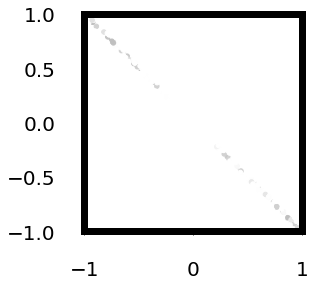

In [ ]:
#Formatting the plot
fig, axs = plt.subplots(1, 1)
plt.autoscale(False)

axs.set_xlim([-1, 1])
axs.set_ylim([-1, 1])
axs.set_aspect(aspect='equal', adjustable='box')


hypothesis_space_2 = axs.scatter(hypothesis[0,:],hypothesis[1,:],c = get_facecolors(probabilities,mode="black"),s=20) #





# Can I increase the number of points as they move? Maybe I can have 10 points in the same location and then all the points go their own way.




# Just moving in the sample space

In [ ]:
def get_linear_interpolated_points(current_points,final_points,frames):
    shape = current_points.shape
    diff = final_points.reshape(-1) - current_points.reshape(-1)
    offset = diff/frames
    interpolated_points = []
    for i in range(frames):
        points_n = current_points.reshape(-1) + offset*i
        interpolated_points.append(points_n.reshape(shape))
    return np.array(interpolated_points)

In [ ]:
training_data[:,:2].shape

In [ ]:
#change this to consider agnostic case

if interpolation_mode == "continuous":

  num_of_samples = 3
  frames_scale = 50 
  frames = frames_scale*num_of_samples




  
  #Sample from the points which are green

  current_points = training_data[:,:2].copy()
  interpolated_points = []
  for i in range(num_of_samples):
      
      #rows = np.random.randint(0,greens_half.shape[0],n)
      final_points = np.random.uniform(-0.4,0.4,[n,2])
      ip = get_linear_interpolated_points(current_points,final_points,frames = frames_scale)
      interpolated_points.append(ip)
      current_points = final_points.copy()
  interpolated_points = np.array(interpolated_points).reshape(-1,n,2)

if interpolation_mode == "iid":
  if find_points == True:
    temp_frames = 100


    iid_samples = np.random.uniform(-0.4,0.4,[temp_frames,n,2])
    interpolation_intermediate = np.matmul(iid_samples,hypothesis)
    interpolation_predictions = np.where(interpolation_intermediate > 0.0, 1, 0)
    interpolation_labels = get_labels(iid_samples[:,:,0].reshape(n*temp_frames),iid_samples[:,:,1].reshape(n*temp_frames),distribution).reshape(temp_frames,-1,1)
    interpolation_in_error =1 - np.sum(np.logical_xor(interpolation_predictions, interpolation_labels),axis=1)/iid_samples.shape[1]
    interpolation_diff = np.abs(interpolation_in_error - true_errors)

    #this works for only 1 hypothesis..make it work for all 8.
    if True:
      how_many_h_red = np.where(interpolation_diff<e*1.5,0,1)
      x = np.sum(how_many_h_red,1)

      red_point_indices = np.where(x > 0)
      white_point_indices = np.where(x == 0)

      white_points = iid_samples[white_point_indices[0][:4],:,:]       ############            NEED MORE RED POINTS?
      red_points = iid_samples[red_point_indices[0][:4],:,:]

      interpolated_points = np.r_[white_points,red_points]
      frames = interpolated_points.shape[0]
      np.save(data_path+"iid_interpolation_"+str(n)+".npy",interpolated_points)



    else:
      white_point_indices = np.where(interpolation_diff<e)
      red_point_indices = np.where(interpolation_diff>e*1.4)
    

      white_points = iid_samples[white_point_indices[0][:4],:,:] ############            NEED MORE RED POINTS?
      red_points = iid_samples[red_point_indices[0][:4],:,:]

      interpolated_points = np.r_[white_points,red_points]

      frames = interpolated_points.shape[0]
      np.save(data_path+"iid_interpolation_"+str(n)+".npy",interpolated_points)


  else:
    interpolated_points = np.load(data_path+"iid_interpolation_"+str(n)+".npy")
    frames = interpolated_points.shape[0]


In [ ]:
if interpolation_mode == "continuous":
  fps=30
  interval = 10
else:
  temp = np.broadcast_to(interpolated_points, (10, 8,sample_size_to_animate_on,2))
  interpolated_points = temp.reshape(80,sample_size_to_animate_on,2,order='F')
  frames = interpolated_points.shape[0]

  fps=10
  interval = 1000

In [ ]:
last_point = interpolated_points[-1,:,:]
last_point_labels = get_labels(last_point[:,0],last_point[:,1],distribution).astype(int)
last_point = np.c_[last_point,last_point_labels]
np.save(data_path  + "training_data_"+name+".npy",last_point)

# Calculate the facecolors to be used in the animation

In [ ]:
#Use lambda here ,as the session crashes

#interpolated points has the shape [frame,n(sample size),2( 2dimensional)]
interpolation_intermediate = np.matmul(interpolated_points,hypothesis)
interpolation_predictions = np.where(interpolation_intermediate > 0.0, 1, 0)

#interpolation_labels = np.where(np.matmul(interpolated_points,labeling_hypothesis) > 0, 1, 0)
interpolation_labels = get_labels(interpolated_points[:,:,0].reshape(n*frames),interpolated_points[:,:,1].reshape(n*frames),distribution).reshape(frames,-1,1)
right_wrong = np.logical_xor(interpolation_labels.reshape(frames,-1),interpolation_predictions[:,:,h_erm])
interpolation_label_facecolors = get_facecolors(right_wrong,mode = "greenred")

interpolation_in_error =1 - np.sum(np.logical_xor(interpolation_predictions, interpolation_labels),axis=1)/interpolated_points.shape[1]
interpolated_in_error_facecolors = get_facecolors(interpolation_in_error,mode="black")

#interpolation_diff = np.abs(interpolation_in_error - true_errors)
#interpolated_facecolors = get_facecolors(interpolation_diff<e,mode="greyred")


# Animation

In [ ]:

def animate(i,interpolated_points,interpolated_in_error_facecolors,interpolation_label_facecolors): #interpolated_in_acc_facecolors,
    
    sample_space_2.set_offsets(interpolated_points[i,:,:])
    sample_space_2.set_facecolors(interpolation_label_facecolors[i,:,:])
    
    #hypothesis_space_1.set_facecolors(interpolated_in_error_facecolors[i,:,:])
    
    hypothesis_space_2.set_facecolors(interpolated_in_error_facecolors[i,:,:])
    current_color.set_facecolors(interpolated_in_error_facecolors[i,h_erm,:])
    
    return sample_space_2,hypothesis_space_2,current_color,#hypothesis_space_1,

In [ ]:
name = "mDataset_"+name

In [ ]:
ani = animation.FuncAnimation(fig, animate, fargs=(interpolated_points,interpolated_in_error_facecolors,interpolation_label_facecolors,),  #interpolated_in_error_facecolors,
            frames=frames, interval=10, repeat=False,blit = True) 

ani.save(videos_path+ name +'_'+str(sample_size_to_animate_on)+'.mp4', fps=30, extra_args=['-vcodec', 'libx264'],savefig_kwargs=dict(facecolor='blue'))